# Simulation of Physical System - to be used by Learning Algo

In [2]:
# run this cell if you have missing libraries
libs = ["numpy","matplotlib","CoolProp","prettytable","tqdm"]
try:
    import subprocess
    for lib in libs:
        subprocess.run(["pip", "install", lib])
except Exception as install_error:
    print(f"Failed to install required libraries: {install_error}")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
#from scipy.integrate import solve_ivp
import CoolProp.CoolProp as CP
from prettytable import PrettyTable
from tqdm import tqdm

$m \cdot a = F$ <br>
$\ddot{x}= \frac{1}{m} \cdot (F_T(p) - F_G - F_H + F_R )$<br>
$\ddot{x}= \frac{1}{m} \cdot (F_T(p) - (m \cdot g_0) - (k \cdot x) + F_R(\dot{x}) )$<br>
<br>
$F_R(\dot{x})= \begin{cases}
  sign(\dot{x}) \cdot 10N, & \text{for } \lvert \dot{x} \rvert > 0.01 \frac{m}{s} \\
  \frac{\lvert \dot{x} \rvert}{0.01 \frac{m}{s}} \cdot sign(\dot{x}) \cdot 10N, & \text{for } \lvert \dot{x} \rvert \leq 0.01 \frac{m}{s}
\end{cases}$<br>
<br>
$F_T(p)= f_{Nozzle}(p)$

In [70]:
H = CP.PropsSI('H','P',300 * 1e5,'T',293, "Nitrogen") # assume Enthalpy constant ofer the whole system
g0 = 9.80665

def F_Thrust_NASA(p_valve,debug=False):
    R = 296.8 # Gas constant of Nitrogen
    gamma = 1.4
    D_th = 0.009 # nozzle throat diameter m
    D_ex = 0.011 # nozzle exit diameter mm
    A_th = ((D_th/4)**2)*np.pi # [m²]
    A_ex = ((D_ex/4)**2)*np.pi # [m²]

    # values over the mach shock
    p_1 = p_valve * 1e5 # [Pa]
    T_1 = CP.PropsSI('T','P',p_1,'H',H, "Nitrogen") # [K]

    md =  (A_th * p_1/np.sqrt(T_1)) * np.sqrt(gamma/R) * ((gamma + 1)/2)**-((gamma + 1)/(gamma - 1)/2) 

    # converge Mach_exit
    M_ex = 2 # Initial value for the exit Mach number
    error = np.inf
    Aex_Ath_target = A_ex / A_th

    if debug:
        while abs(error) > 0.000001:
            Aex_Ath =  (((gamma+1)/2)**-((gamma+1)/(gamma-1)/2)) / M_ex * (1 + M_ex**2 * (gamma-1)/2)**((gamma+1)/(gamma-1)/2) 
            
            error = Aex_Ath-Aex_Ath_target
            M_ex_step = 0.0000001 + M_ex*0.0005
            if error > 0:
                M_ex -= M_ex_step
            else:
                M_ex += M_ex_step
            print(error,end='\r',flush=True)
    else:
        # precomputed for Aex_Ath_target = 1.49383
        M_ex = 1.84790
    
    T_2 = T_1 * ((1+ ((gamma-1)/2)*M_ex**2)**(-1))
    p_2 = p_1 * ((1+ ((gamma-1)/2)*M_ex**2)**(-((gamma)/(gamma-1))))

    v_ex = M_ex * np.sqrt(gamma*R*T_2)

    p_infinity = 1 * 1e5 # [Pa]

    F_T = md * v_ex + (p_2 - p_infinity) * A_ex
    
    if debug:
        x = PrettyTable()
        x.field_names = ["variable", "value", "unit"]
        x.add_row(["p_1", f'{p_1/1e5:10.2f}', "bar"])
        x.add_row(["T_1", f'{T_1:10.2f}', "K"])
        x.add_row(["md", f'{md:10.5f}', "kg/s"])
        x.add_row(["A_ex / A_th", f'{Aex_Ath_target:10.5f}', ""])
        #x.add_row(["A_ex / A_th", f'{Aex_Ath:10.5f}', ""])
        x.add_row(["M_ex", f'{M_ex:10.5f}', ""])
        x.add_row(["p_2", f'{p_2/1e5:10.2f}', "bar"])
        x.add_row(["T_2", f'{T_2:10.2f}', "K"])
        x.add_row(["v_ex", f'{v_ex:10.2f}', "m/s"])
        x.add_row(["i_sp", f'{v_ex/g0:10.2f}', "s"])
        x.add_row(["F_T", f'{F_T:10.2f}', "N"])
        print(x)

    return F_T

F_Thrust_NASA(10,debug=True)

+-------------+------------+------+
|   variable  |   value    | unit |
+-------------+------------+------+
|     p_1     |      10.00 | bar  |
|     T_1     |     256.62 |  K   |
|      md     |    0.03946 | kg/s |
| A_ex / A_th |    1.49383 |      |
|     M_ex    |    1.84790 |      |
|     p_2     |       1.62 | bar  |
|     T_2     |     152.49 |  K   |
|     v_ex    |     465.15 | m/s  |
|     i_sp    |      47.43 |  s   |
|     F_T     |      19.82 |  N   |
+-------------+------------+------+


19.820768187440265

In [59]:
H = CP.PropsSI('H','P',300 * 1e5,'T',293, "Nitrogen") # assume Enthalpy constant ofer the whole system
g0 = 9.80665

def F_Thrust(p_valve,debug=False):
    # p_valve in [bar]
    
    R = 296.8 # Gas constant of Nitrogen
    gamma = 1.4
    D_th = 0.009 # nozzle throat diameter m
    D_ex = 0.011 # nozzle exit diameter mm
    A_th = ((D_th/4)**2)*np.pi # [m²]
    A_ex = ((D_ex/4)**2)*np.pi # [m²]

    # values over the mach shock
    p_1 = p_valve * 1e5 # [Pa]
    T_1 = CP.PropsSI('T','P',p_1,'H',H, "Nitrogen") # [K]
    
    md = ((A_th*p_1)/np.sqrt((T_1*R)/gamma))*((gamma+1)/2)**((-gamma-1)/(2*(gamma-1))) # [kg/s]
    #print(md)

    # converge Mach number
    M_ex_0 = 4 # Initial value for the exit Mach number
    error = np.inf

    while error > 0.001:
        M_ex = M_ex_0-((((gamma+1)/2)**(-(gamma+1)/(2*(gamma-1)))*((1+(gamma-1)/2*M_ex_0**2)**((gamma+1)/(2*(gamma-1)))/M_ex_0)-A_ex/A_th)/((2*(M_ex_0**2-1)*((gamma-1)*M_ex_0**2+2)**((gamma+1)/(2*(gamma-1))-1))/((gamma+1)**((gamma+1)/(2*(gamma-1)))*M_ex_0**2)))
        error = abs(M_ex-M_ex_0)
        M_ex_0 = M_ex
    #print(M_ex)
    
    T_2 = ((1 + ((gamma - 1)/2)*M_ex**2)**(-1))*T_1
    p_2 = ((1 + ((gamma - 1)/2)*M_ex**2)**(-gamma/(gamma - 1)))*p_1
    v_ex = M_ex * np.sqrt(gamma*R*T_2)
    p_infinity = 1 * 1e5 # [Pa]
    
    F_T = md * v_ex + (p_2 - p_infinity) * A_ex

    if debug:
        x = PrettyTable()
        x.field_names = ["variable", "value", "unit"]
        x.add_row(["p_1", f'{p_1/1e5:10.2f}', "bar"])
        x.add_row(["T_1", f'{T_1:10.2f}', "K"])
        x.add_row(["md", f'{md:10.5f}', "kg/s"])
        x.add_row(["M_ex", f'{M_ex:10.5f}', ""])
        x.add_row(["p_2", f'{p_2/1e5:10.2f}', "bar"])
        x.add_row(["T_2", f'{T_2:10.2f}', "K"])
        x.add_row(["v_ex", f'{v_ex:10.2f}', "m/s"])
        x.add_row(["i_sp", f'{v_ex/g0:10.2f}', "s"])
        x.add_row(["F_T", f'{F_T:10.2f}', "N"])
        print(x)

    return F_T

F_Thrust(10,debug=True)

+----------+------------+------+
| variable |   value    | unit |
+----------+------------+------+
|   p_1    |      10.00 | bar  |
|   T_1    |     256.62 |  K   |
|    md    |    0.03946 | kg/s |
|   M_ex   |    1.84882 |      |
|   p_2    |       1.61 | bar  |
|   T_2    |     152.42 |  K   |
|   v_ex   |     465.28 | m/s  |
|   i_sp   |      47.45 |  s   |
|   F_T    |      19.82 |  N   |
+----------+------------+------+


19.820766231402

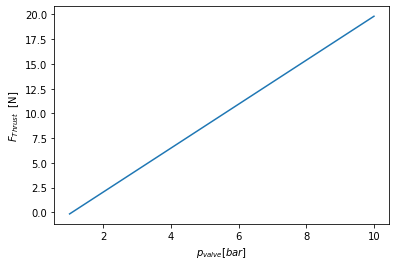

In [66]:
# test F Thrust over pressure
x = np.linspace(1,10,1000)
y = []
for i in x:
    y.append(F_Thrust(i))
plt.plot(x, y)
plt.ylabel('$F_{Thrust}$  [N]')
plt.xlabel('$p_{valve}  [bar]$')
plt.savefig('thrust.png', dpi=300)
plt.show()

In [68]:
# 𝐹𝑅𝑅 ≈ 10𝑁 Rolling - Resistance against velocity
# FG = m

m = 3.5 # kg
F_T = 34.5 #F_Thrust(10) # N
F_RR = 10 # N
k  = 6 # N /m

# resistance modelling - smoothed to stablize model
def F_R(v):
    v_thr = 0.01
    
    if abs(v) > v_thr:
        F_R = np.sign(v)*F_RR
    else:
        F_R = (abs(v)/v_thr)*np.sign(v)*F_RR
    return F_R

def dynamic_restriction(p_set,p_set_old):
    # main valve opening / closing restriction
    # 0 % = 0 bar to 100% = 10 bar
    
    dp = (p_set-p_set_old) # [bar]
    sim_step = 1/60 # [s]
    dp_dt = dp/sim_step # [bar/s]
    
    direction = (dp > 0) # True = opening, False = closing

    # opening restrictions
    # dp/dt = 10 bar / 0.825 s
    dp_dt_opening = 10 / 0.825

    # closing restrictions
    # dp/dt = 10 bar / 1.7 s
    dp_dt_closing = 10 / 1.7

    # if requested change in pressure is to high
    # return maximum allowed pressure over the next sim step (1/60 s)

    if direction:
        # opening
        if dp_dt > dp_dt_opening:
            # compute max allowed for new p_set
            p_set = dp_dt_opening * sim_step + p_set_old
            
    if not direction:
        # closing
        if dp_dt > dp_dt_closing:
            # compute max allowed for new p_set
            p_set = dp_dt_closing * sim_step + p_set_old

    return p_set


def ode(t, y):
    """
    Defines the system of ODEs for free fall.

    Parameters:
        t (float): Time.
        y (array): Array containing the position and velocity [x, v].

    Returns:
        dydt (array): Array containing the derivatives [v, a].
    """
    global F_T
    
    x = y[0]
    v = y[1]
    
    a = (1/m)*(F_T - (m*g0) - (k *x) - (F_R(v)))
    # restrict movement to be not able to go below 0 in position
    if x == 0 and a < 0:
        # would move into negative realm
        a = 0
    
    dydt = np.array([v, a])
    return dydt

def rk4_e(f, y, h, t): # runge kutta 4th order explicit
    # runge kutte 4th order explicit
    tk_05 = t + 0.5*h
    yk_025 = y + 0.5 * h * f(t, y)
    yk_05 = y + 0.5 * h * f(tk_05, yk_025)
    yk_075 = y + h * f(tk_05, yk_05)
    
    return y + h/6 * (f(t, y) + 2 * f(tk_05, yk_025) + 2 * f(tk_05, yk_05) + f(t+h, yk_075))

34.323274999999995


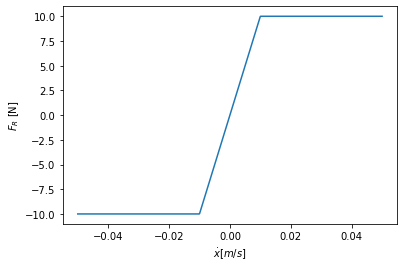

In [456]:
# resistance modelling - smoothed around zero to stablize model
x = np.linspace(-0.05,0.05,1000)
y = []
for i in x:
    y.append(F_R(i))
plt.plot(x, y)
plt.ylabel('$F_{R}$ [N]')
plt.xlabel('$\dot{x} [m/s]$')
plt.show()

In [457]:
def plot(states, time):
    num_states = states.shape[0]

    plt.figure(figsize=(10, 2*num_states))

    names = ["position [m]","velocity [m/s]","p_set [bar]","error [m]"]
    colors = ["tab:blue","tab:orange","tab:green","tab:red"]

    for i in range(num_states):
        plt.subplot(num_states, 1, i + 1)
        plt.plot(time, states[i, :], label=names[i],color=colors[i])
        if i == 3:
            plt.fill_between(time, 0, states[i, :], color=colors[i], alpha=0.5)
        plt.ylabel(names[i])
        plt.legend()
        plt.grid(True)

    plt.xlabel('Time [steps]')
    plt.tight_layout()
    plt.show()

done


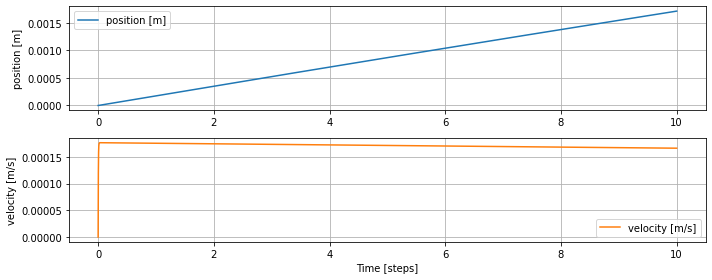

In [458]:
h = 1/1000              # stepsize in seconds
t0 = 0                  # initial time in seconds
tn = 10                  # final time in seconds

time = np.linspace(t0, tn, int((tn-t0)/h)+1)
n = len(time)

y0_ode = np.array([0,0]) # initial x, v

states_ode = np.zeros((len(y0_ode), n))

y_ode = y0_ode

for ii, t in enumerate(time):

    states_ode[:, ii] = y_ode
            
    y_ode = rk4_e(ode, y_ode, h, t)
    
    #print(f'Step {ii+1} of {n}'.format(),end="\r",flush=True)

print('done')
plot(states_ode,time)

In [459]:
# Alternative Integration via scipy

# Initial conditions [initial_position, initial_velocity]
#initial_conditions = [0, 0]

# Time span for the simulation (0 to 5 seconds, for example)
#t_span = (0, 5)

# Solve the ODE using solve_ivp
#solution = solve_ivp(ode, t_span, initial_conditions, method='RK45')

# Extract results
#time = solution.t
#position = solution.y[0]
#velocity = solution.y[1]

In [460]:
def sim_step(y,p=None):
    h = 1/600              # stepsize in seconds
    t0 = 0                  # initial time in seconds
    tn = 1/60               # final time in seconds
    
    time = np.linspace(t0, tn, int((tn-t0)/h)+1)

    # update Thrust
    global F_T
    F_T = F_Thrust(p)
    
    for t in time:
        y = rk4_e(ode, y, h, t)
        
    return y

In [461]:
# propagate
y = np.array([0,0])
for i in range(10*60):
    y = sim_step(y,p=12) # sim_step(y,p=10)
y

array([ 6.62911666e+00, -5.93204519e-03])

In [462]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

class PIDController:
    def __init__(self, Kp, Ki, Kd):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.prev_error = 0
        self.integral = 0

    def ctrl(self, y, x_target):
        x_is = y[0]
        # v_is = y[1]
        error = x_target - x_is

        # Proportional term
        P = self.Kp * error

        # Integral term
        self.integral += error
        I = self.Ki * self.integral

        # Derivative term
        derivative = error - self.prev_error
        D = self.Kd * derivative
        self.prev_error = error

        # Calculate the control output
        control_output = P + I + D

        # map control value to the range [1 bar .. 12 bar]
        p_min = 1
        p_max = 10
        
        p_set = sigmoid(control_output) * (p_max - p_min) + p_min
        
        return p_set

100%|████████████████████████████████████████████████████████████████████████████| 2400/2400 [00:01<00:00, 1261.25it/s]


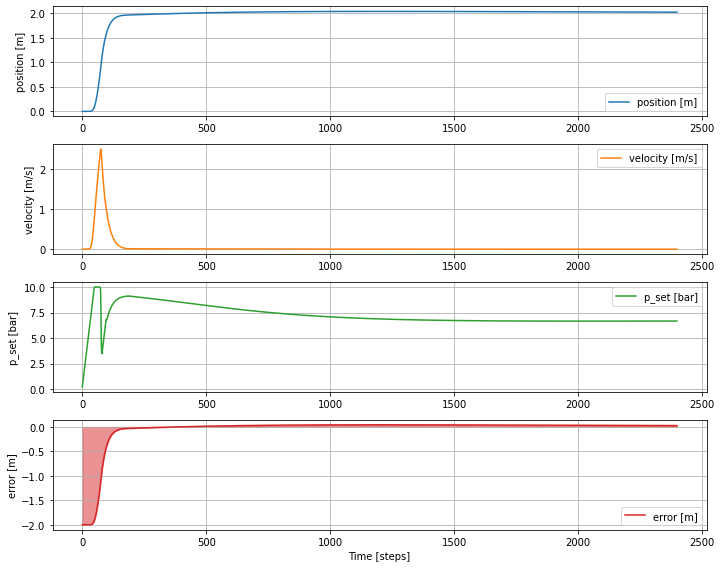

In [522]:
x_target = 2 # [m]
y = np.array([0,0])
t = 40 # simulation time [s]
n = t * 60 # simulation simulates always 1/60 s in one window
log = np.zeros((len(y)+2, n))
# log[0,:] -> position
# log[1,:] -> velocity
# log[2,:] -> p_set

contr = PIDController(20,0.01,500) # initialize controller
p_set_old = 0
time = range(n)
for i in tqdm(time):
    p_set = contr.ctrl(y,x_target)
    p_set = dynamic_restriction(p_set,p_set_old)
    y = sim_step(y,p_set)
    p_set_old = p_set
    
    log[0, i] = y[0]
    log[1, i] = y[1]
    log[2,i] = p_set
    log[3,i] = y[0]-x_target

plot(log,time)